# Prelim

## Imports

In [32]:
import os
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import spacepy
from spacepy.coordinates import Coords
from spacepy.time import Ticktock
from spacepy import pycdf

from time import strftime, localtime
from datetime import datetime, timedelta
import pandas as pd

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [33]:
# LUNA Directories
luna_clus_dir = 'Z:/spacecraft/cluster/c1/C1_CP_FGM_SPIN/'
luna_omni_dir = 'Z:/omni/omni_1min_yearly/'

# Saving processed data
proc_clus_dir = '../Data/Processed_Data/Cluster/'
proc_omni_dir = '../Data/Processed_Data/OMNI/'

R_E = 6370      # Cluster takes 1 earth radius to be 6370 km

sample_size = 'min'
bin_size = pd.Timedelta(minutes=1) # Binning data into 1 minute intervals

# Data to be extracted from cluster
cluster_variables = {
    'epoch' : 'time_tags__C1_CP_FGM_SPIN',      # extracts the epoch time in milliseconds (scalar).
    'r'     : 'sc_pos_xyz_gse__C1_CP_FGM_SPIN', # extracts the position in km from centre of Earth (vector).
    'B_mag' : 'B_mag__C1_CP_FGM_SPIN',          # extracts the fgm data in nT (magnitude).
    'B'     : 'B_vec_xyz_gse__C1_CP_FGM_SPIN',  # extracts the fgm data in nT (vector).
}
time_column = list(cluster_variables.keys())[0]

omni_variables = ['time','B_field','pressure']

## Definitions

### General File Handling

In [34]:
def add_to_cdf(df, file):
    """
    Adds columns from a DataFrame to an existing CDF file, creating new variables or extending existing ones.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing data to be added to the CDF file. Each column in the DataFrame is added 
        as a new variable or appended to an existing variable in the CDF file.
        
    file : pycdf.CDF
        Open CDF file to which the data will be added. New variables are created if they do not already 
        exist in the file, or existing variables are extended with the new data.

    Returns
    -------
        None: procedure just adds to attributes.
    """
    # Write each column in the DataFrame to the CDF file
    for column in df.columns:
        new_data = df[column].to_numpy()
        
        if column not in file:
            # Create new variable in the CDF if it doesn’t exist
            file[column] = new_data

            # Add units attribute
            if 'r_' in column:
                file[column].attrs['units'] = 'Re'
            elif 'B_' in column:
                file[column].attrs['units'] = 'nT'
            elif 'epoch' in column:
                file[column].attrs['units'] = 'cdf_epoch'
            elif 'p_' in column:
                file[column].attrs['units'] = 'nPa'
        else:
            # If the column already exists, extend the existing data
            file[column] = np.concatenate((file[column][...], new_data))

#### Error Logging

In [35]:
def create_log_file(log_file_path):
    """
    Creates a log file at the specified path with the current datetime as the first line, 
    if the file does not already exist.

    Parameters
    ----------
    log_file_path : str
        The path where the log file will be created.
        
    Returns
    -------
    None: procedure just creates file.
    """
    if not os.path.exists(log_file_path):
        with open(log_file_path, 'w') as log_file:
            log_file.write(f"Log created on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

In [36]:
def log_missing_file(log_file_path, file_path):
    """
    Appends the name of a missing file to the log file.

    Parameters
    ----------
    log_file_path : str
        The path to the log file where the missing file name will be appended.
    
    file_path : str
        The full path of the file that was not added. The file name will be extracted and logged.

    Returns
    -------
    None: procedure just updates file.
    """
    file_name = os.path.basename(file_path)
    with open(log_file_path, 'a') as log_file:
        log_file.write(f'{file_name} not added\n')

### Cluster

In [37]:
def process_cluster_files(directory, data_directory, variables, sample_interval='min', time_col='epoch', a_year=None):
    """
    Processes CDF files from a specified directory, extracts specified variables, and appends the data 
    to a new or existing CDF file. Additionally, logs files that could not be processed.

    Parameters
    ----------
    directory : str
        The path to the directory containing the CDF files to process.
    
    data_directory : str
        The directory where processed CDF files will be saved.
    
    variables : dict
        Dictionary where keys are the variable names for the resulting DataFrame, 
        and values are the variable codes used to extract data from the CDF files.
    
    sample_interval : str, optional
        The interval for resampling the data. Default is 'min' for minute intervals.
    
    time_col : str, optional
        The name of the column in the DataFrame containing time data (in CDF epoch format).
        Default is 'epoch'.
    
    a_year : str, optional
        The year to filter CDF files by. If None, all years in the directory are processed.

    Returns
    -------
    None
        The function processes the data and appends it to a CDF file in the `data_directory`.
    """

    files_by_year = get_cluster_files(directory, year=a_year)
    
    directory_name = os.path.basename(os.path.normpath(directory))
    log_file_path = os.path.join(data_directory, f'{directory_name}_not_added_files.txt') # stores not loaded files
    create_log_file(log_file_path)

    # Process each year's files
    for year, files in files_by_year.items():
            
        output_file = os.path.join(data_directory, f'{directory_name}_{year}.cdf')
        
        with pycdf.CDF(output_file, create=not os.path.exists(output_file)) as cdf_out:
            cdf_out.readonly(False)
            
            # Loop through each daily file in the year
            for cdf_file in files:
    
                try: # Bad data check
                    data_dict = extract_cluster_data(cdf_file, variables)
                    data_df = pd.DataFrame(data_dict)

                except (AttributeError, ValueError) as e:
                    # Append an entry to the log file
                    log_missing_file(log_file_path, cdf_file)
                    continue

                # Bin the data in one-minute intervals
                data_df = resample_cluster_data(data_df, time_col=time_col, sample_interval=sample_interval)

                # Append the resampled data to the CDF file
                add_to_cdf(data_df, cdf_out)

#### Processing

In [38]:
def get_cluster_files(directory, year=None):
    """
    Retrieves CDF files from a specified directory, optionally filtered by a specific year.

    Parameters
    ----------
    directory : str
        The path to the directory containing the CDF files to search.
    
    year : str, optional
        The year to filter the CDF files by. If not specified, all CDF files in the directory are retrieved.

    Returns
    -------
    dict
        A dictionary where the keys are years (as strings) and the values are lists of file paths
        for CDF files associated with that year.
    """
    files_by_year = {}

    # Build the search pattern based on the presence of a specific year
    if year:
        pattern = os.path.join(directory, f'*__{year}*.cdf')  # Match only files with the given year
    else:
        pattern = os.path.join(directory, '*.cdf')  # Match all .cdf files if no year is specified

    # Use glob to find files matching the pattern
    for cdf_file in sorted(glob.glob(pattern)):
        # Extract the year from the filename assuming format data-name__YYYYMMDD_version.cdf
        file_year = os.path.basename(cdf_file).split('__')[1][:4]
        files_by_year.setdefault(file_year, []).append(cdf_file)

    if year and str(year) not in files_by_year:
        raise ValueError(f"No files found for the specified year: {year}")

    return files_by_year

In [39]:
def extract_cluster_data(cdf_file, variables):
    """
    Extracts specified variables from a CDF file and returns them in a dictionary.

    Parameters
    ----------
    cdf_file : str
        Path to the CDF file to read.
        
    variables : dict
        Dictionary where keys are the variable names (as strings) to be used in the output,
        and values are the corresponding variable codes (as strings) used to extract data 
        from the CDF file.

    Returns
    -------
    dict :
        A dictionary where the keys are the variable names and the values are the corresponding 
        data arrays. For vector variables, the components are stored as separate keys with '_x_GSE', 
        '_y_GSE', and '_z_GSE' suffixes.
    """
    
    # Initialise a dictionary to store the data
    data_dict = {}

    # Load the CDF file (auto closes)
    with pycdf.CDF(cdf_file) as cdf:
    
        # Loop through the dictionary of variables and extract data
        for var_name, var_code in variables.items():
            data = cdf[var_code][...]  # Extract the data using the CDF variable code
            
            if data.ndim == 2 and data.shape[1] == 3:  # Assuming a 2D array for vector components
                if var_name == 'r':
                    data /= R_E # scales distances to multiple of Earth radii
                
                # Split into components (e.g. x, y, z)
                data_dict[f'{var_name}_x_GSE'] = data[:, 0]
                data_dict[f'{var_name}_y_GSE'] = data[:, 1]
                data_dict[f'{var_name}_z_GSE'] = data[:, 2]
            # Scalar data
            else:
                # Store the data in the dictionary with the desired variable name
                data_dict[var_name] = data # pycdf extracts as datetime - no conversion from epoch needed
    
    return data_dict

In [61]:
def resample_cluster_data(df, time_col='epoch', sample_interval='min'):
    """
    Resamples time series data in a DataFrame to specified intervals, calculating the mean of each bin 
    and removing rows with NaN values. The time for each bin is set to the beginning of the bin in CDF epoch format.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing time data (in CDF epoch format) and other data columns.
        
    time_col : str, optional
        Name of the column containing time data to be resampled. Defaults to 'epoch'.
        
    sample_interval : str, optional
        The sampling interval to use for resampling. Defaults to 'min' (1-minute intervals).

    Returns
    -------
    pandas.DataFrame
        A DataFrame resampled to the specified interval with mean values calculated for each bin.
        The time for each bin corresponds to the beginning of the bin (not the midpoint), and is in CDF epoch format.
    """
    df['utc'] = df[time_col].dt.floor(sample_interval)
    df.set_index('utc', inplace=True) # Set 'time' as the index for time-based grouping
    
    df_resampled = df.resample(sample_interval).mean().dropna() # Resample to 1-minute bins and drop NaNs
    
    # convert utc back to cdf epoch
    utc_times = df_resampled.index.to_pydatetime()
    df_resampled['epoch'] = Ticktock(utc_times, 'UTC').CDF
    
    df_resampled.reset_index(inplace=True) # Reset index to make 'utc' a column again
    df_resampled.drop(columns=['segment', 'utc'], inplace=True, errors='ignore') # Drop 'segment' and 'time' columns
    
    return df_resampled

### OMNI

ASCII refers to each entry/column in a row as a word:
*  Word 0 : Year			            1995 ... 2006
*  Word 1 : Day			                1 ... 365 or 366
*  Word 2 : Hour			            0 ... 23
*  Word 3 : Minute                      0 ... 59 at start of average
*  Word 4 : ID for IMF spacecraft
*  Word 5 : ID for SW Plasma spacecraft
*  Word 14 : Bx, nT (GSE, GSM)
*  Word 15 : By, nT (GSE)
*  Word 16 : Bz, nT (GSE)
*  Word 17 : By, nT (GSM)
*  Word 18 : Bz, nT (GSM)
*  Word 27 : Flow pressure, nPa
 
Important to note that for words 4 and 5, if there's any bad data in their sets, their flag is set to 99. I.e. if either of them is 99, there's bad data.

In [57]:
def process_omni_files(directory, data_directory, variables, imf_data=True, plasma_data=False, a_year=None):
    """
    Processes a list of CDF files and extracts the specified variables, returning a pandas DataFrame.

    Parameters
    ----------
    directory : str
        The path to the directory containing the cdf files.
        
    data_directory : str
        The path to the directory where to save the processed cdf files.
        
    start_year : int
        The starting year of the range for which files should be selected.
        
    end_year : int
        The ending year of the range for which files should be selected.
        
    variables : dict
        Dictionary where keys are the variable names to be used in the dataframe, 
        and values are the variable codes used to extract data from the CDF file.

    Returns
    -------
        None : the procedure processes data to an external cdf file.
    """
    
    # Gather all .asc files in the directory
    files_to_process = get_omni_files(directory, year=a_year)
    
    directory_name = os.path.basename(os.path.normpath(directory))
    log_file_path = os.path.join(data_directory, f'{directory_name}_not_added_files.txt') # stores not loaded files
    create_log_file(log_file_path)
    
    # Process each file
    for asc_file in files_to_process:
        # Extract the year from the filename assuming format omni_minYYYY.asc
        file_year = os.path.basename(asc_file).split('_')[1][3:7]

        # Define the output file name and path
        output_file = os.path.join(data_directory, f'{directory_name}_{file_year}.cdf')
        
        with pycdf.CDF(output_file, create=not os.path.exists(output_file)) as file_out:
            file_out.readonly(False)

            add_to_cdf(extract_omni_data(asc_file, variables), file_out)

#### Processing

In [56]:
def get_omni_files(directory, year=None):
    """
    Retrieves .asc files from a specified directory, optionally filtered by a specific year.

    Parameters
    ----------
    directory : str
        The path to the directory containing the .asc files to search.
    
    year : str, optional
        The year to filter the .asc files by. If not specified, all .asc files in the directory are retrieved.

    Returns
    -------
    list :
        A sorted list of file paths for .asc files in the specified directory that match the search pattern.
    """
    
    # Build the search pattern based on the presence of a specific year
    if year:
        pattern = os.path.join(directory, f'*_{year}*.asc')  # Match files with the specified year
    else:
        pattern = os.path.join(directory, '*.asc')  # Match all .asc files if no year is specified

    # Use glob to find files matching the pattern
    files_to_process = sorted(glob.glob(pattern))

    if not files_to_process:
        raise ValueError(f"No .asc files found in the directory: {directory}")

    return files_to_process

In [75]:
def extract_omni_data(asc_file, variables):
    """
    Loads specified variables from an ASCII file and returns a DataFrame with extracted data.

    Parameters
    ----------
    asc_file : str
        The path to the ASCII file.
        
    variables : dict
        Dictionary where keys are the variable names to be used in the dataframe, 
        and values are the variable codes used to extract data from the file.

    Returns
    -------
    pd.DataFrame :
        A DataFrame with columns for each requested variable.
    """
    data_set = np.array(np.loadtxt(asc_file)) # each element is a row; one row per minute
    
    # Initialise a df to store the data
    df = pd.DataFrame()
    # Adds spacecraft id for filtering
    df['imf_sc']    = data_set[:,4]
    df['plasma_sc'] = data_set[:,5]
    
    for var in variables:
        
        if var == 'time':

            years = data_set[:,0].astype(int)
            days = data_set[:,1]
            hours = data_set[:,2]
            minutes = data_set[:,3]

            dates = [
                datetime(year, 1, 1)+timedelta(days=day-1, hours=hour, minutes=minute)
                for year, day, hour, minute in zip(years, days, hours, minutes)
            ]

            times = Ticktock(dates, 'UTC').CDF # Converts datetime to cdf epoch for consistency with cluster data

            df['epoch'] = times

        elif var == 'B_field':

            # Use this over magnitude of average Bx, By, Bz
            df['B_mag']   = data_set[:,13]
            df['B_x_GSE'] = data_set[:,14]
            df['B_y_GSE'] = data_set[:,15]
            df['B_z_GSE'] = data_set[:,16]
            
            # A sc id of 99 indicates bad data
            df.loc[df['imf_sc'] == 99, ['B_mag','B_x_GSE','B_y_GSE','B_z_GSE']] = np.nan

        elif var == 'pressure':
            
            plasma_sc = data_set[:,5] 
            
            # from README, Flow pressure = (2*10**-6)*Np*Vp**2 nPa (Np in cm**-3, Vp in km/s, subscript "p" for "proton")
            
            df['p_flow'] = data_set[:,27]
            
            # A sc id of 99 indicates bad data
            df.loc[df['plasma_sc'] == 99, 'p_flow'] = np.nan
        
        else:
            raise ValueError(f"Unknown variable {var}")
    
    df = df.drop(columns=['imf_sc','plasma_sc'])
    
    return df

### Reading Processed Data

In [44]:
def import_cdf_data(directory, file_keyword, start, end, time_col='epoch'):
    """
    Imports and processes CDF files from a specified directory, filtering by keyword and date range.

    Parameters
    ----------
    directory : str
        The path to the directory containing the CDF files.
    
    file_keyword : str
        A keyword to filter the CDF files by. Only files whose names contain this keyword will be processed.
    
    start : datetime
        The start of the date range for filtering the CDF files. Only data from files within this range will be included.
    
    end : datetime
        The end of the date range for filtering the CDF files. Only data from files within this range will be included.
    
    time_col : str, optional
        The name of the column containing time data in CDF epoch format. Defaults to 'epoch'.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the merged and filtered data from the CDF files. The DataFrame will have a 'time' column 
        (converted from CDF epoch to datetime) as the index, and it will be filtered to the specified date range.
    """
    
    # Find all .cdf files containing the specified keyword in their names and within the date range
    cdf_files = []
    for file in sorted(glob.glob(os.path.join(directory, f'*{file_keyword}*.cdf'))):
        # Extract the year from the filename, assuming format like 'data-name__YYYY_version.cdf'
        file_year = os.path.basename(file).split('_')[-1][:4]
        
        # Check if the year is within the desired range
        if start.year <= int(file_year) <= end.year:
            cdf_files.append(file)
    
    # Merge the selected files
    if cdf_files:
        merged_data = spacepy.pycdf.concatCDF([spacepy.pycdf.CDF(f) for f in cdf_files])
        
        df = read_merged_cdf(merged_data)
        
        # Converts epoch time to datetimes
        df[time_col] = Ticktock(df[time_col].to_numpy(), 'CDF').UTC
        df = df.rename(columns={time_col: 'time'})
        df.attrs['units']['time'] = 'datetime'
        df.set_index('time', inplace=True) # Set 'time' as the index
        
        # Filters data to be only within desired date range
        df = slice_dataframe(df, start, end)
        
        if df.empty:
            raise ValueError(f'No data found in the specified date range.')
        
        return df
        
    else:
        raise FileNotFoundError(f'No CDF files found containing "{file_keyword}" in the specified date range.')

#### Processing

In [45]:
def read_merged_cdf(merged_data):
    """
    Reads data from a merged CDF object and stores it in a pandas DataFrame.

    Parameters
    ----------
    merged_data : spacepy.pycdf.CDF
        The merged CDF object containing the data to be read.

    Returns
    -------
    pd.DataFrame :
        A DataFrame containing all data from the merged CDF, with each variable as a column. 
        The units for each variable are stored as attributes in the DataFrame.
    """
    data_dict = {}
    units_dict = {}

    for var in merged_data:
        data_dict[var] = merged_data[var][...]
        units_dict[var] = merged_data[var].attrs.get('units', None)  # Extract units if available

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(data_dict)
    df.attrs['units'] = units_dict # stores the units
    
    return df

In [46]:
def slice_dataframe(df, start, end):
    """
    Slices a DataFrame to include only rows within the specified date range.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to be sliced. The DataFrame's index is expected to contain datetime values.
    start : datetime
        The start date for slicing the DataFrame. Rows with a timestamp equal to or later than this date will be included.
    end : datetime
        The end date for slicing the DataFrame. Rows with a timestamp before this date will be included.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing only the rows within the specified date range (inclusive of the start date, exclusive of the end date).
    """
    mask = (df.index >= start) & (df.index < end)

    return df.loc[mask]

### Merging and Filtering

In [47]:
def filter_sw(df, *args):
    """
    Filters a DataFrame based on a specified model or threshold to restrict Cluster data 
    to instances 'in the solar wind'.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to be filtered. It must contain columns such as 'r_x_GSE_C1' and 'r_mag'.
    *args : tuple
        A tuple where:
        - The first argument specifies the model ('x_dist', 'r_dist', or 'r_dist_x_dist') used for filtering.
        - Any additional arguments specify custom threshold values for filtering. 
          If no threshold is provided, default values are used (e.g., 15 for distance-based models).

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing only the rows that satisfy the filtering conditions based on the specified model and threshold.
    """
    if not args:
        raise ValueError('Please specify at least one argument for the model type.')
    
    model = args[0]
    thresholds = args[1:]  # Any additional values passed for custom thresholds
    
    match model:
        case 'x_dist':
            threshold = thresholds[0] if thresholds else 15
            mask = df['r_x_GSE_C1'] > threshold
        case 'r_dist':
            threshold = thresholds[0] if thresholds else 15
            mask = df['r_mag'] > threshold
        case 'r_dist_x_dist':
            threshold_r = thresholds[0] if len(thresholds) > 0 else 15
            threshold_x = thresholds[1] if len(thresholds) > 1 else 12
            mask = (df['r_mag'] > threshold_r) & (df['r_x_GSE'] > threshold_x)
        case _:
            raise ValueError(f'Unknown model type: {model}')
            
    filtered = df.loc[mask]
    filtered.attrs['units'] = df.attrs['units']
    
    return filtered

In [70]:
def merge_dataframes(df1, df2, suffix_1, suffix_2):
    """
    Merges two DataFrames based on their indices and relabels their columns with specified suffixes.

    Parameters
    ----------
    df1 : pandas.DataFrame
        The first DataFrame to be merged.
    df2 : pandas.DataFrame
        The second DataFrame to be merged.
    suffix_1 : str
        The suffix to be added to the column names of the first DataFrame (`df1`).
    suffix_2 : str
        The suffix to be added to the column names of the second DataFrame (`df2`).

    Returns
    -------
    pandas.DataFrame
        A merged DataFrame with the columns from both input DataFrames, 
        with the specified suffixes appended to their names.
    """
    # Relabel columns with specified suffixes
    new_df1 = relabel_columns(df1, suffix_1)
    new_df2 = relabel_columns(df2, suffix_2)
    
    # Merge DataFrames based on their indices
    merged = new_df1.merge(new_df2, left_index=True, right_index=True)
    
    # Combine units attributes
    merged.attrs['units'] = new_df1.attrs['units']
    merged.attrs['units'].update(new_df2.attrs['units'])
    return merged.dropna()

In [49]:
def relabel_columns(df, label):
    """
    Relabels the columns of a DataFrame by appending a suffix to each column name.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame whose columns are to be relabeled.
    label : str
        The suffix to be appended to each column name.

    Returns
    -------
    pandas.DataFrame
        A new DataFrame with the columns renamed by appending the specified label.
        The `attrs['units']` attribute is also updated to match the new column names.
    """
    old_cols = list(df.columns)
    new_cols = list(df.columns + f'_{label}')
    units = list(df.attrs['units'].values())
    
    # Map old column names to new column names
    label_dict = dict(zip(old_cols,new_cols))
    
    new_df = df.rename(columns=label_dict) # Rename columns
    new_df.attrs['units'] = dict(zip(new_cols, units)) # Update the units

    return new_df

### Plotting

#### Against time

In [50]:
def segment_dataframe(df, delta=pd.Timedelta(minutes=1)):
    """
    Adds a 'segment' column to the DataFrame based on time gaps exceeding a threshold. 
    This is useful for segmenting time-series data into separate chunks, typically for plotting purposes.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing time-series data to be segmented. The DataFrame must have a DateTimeIndex.
    delta : pd.Timedelta, optional
        The time gap threshold for segmenting the data. If the time difference between consecutive rows exceeds this value,
        a new segment is started. Defaults to 1 minute.

    Returns
    -------
    None : the input DataFrame is modified in place, adding a 'segment' column to represent the segmented data.
    """
    df.drop(columns=['segment']) # if one already exists
    
    # Calculate the time differences between consecutive rows
    time_diffs = df.index.diff()
    
    # Create the 'segment' column in a single operation
    df.insert(0, 'segment', (time_diffs > delta).cumsum())

In [53]:
def plot_scalar_field(df, data_col, source, keys, delta=pd.Timedelta(minutes=1)):
    """
    Plots a scalar field (e.g., a specific data column) over time.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing the data to be plotted. The DataFrame should have a DateTimeIndex
        and include the specified column for the scalar field.

    data_col : str
        The label for the scalar field to be plotted, such as 'pressure' or 'temperature'. This 
        should be the name of the column to plot, prefixed by the appropriate source key.

    source : str
        The key identifying the data source to be used in plotting. This is used to access the 
        appropriate field in the DataFrame based on the `keys` dictionary.

    keys : dict
        A dictionary mapping sources to keys. The `keys[source]` provides the specific key used 
        to fetch the corresponding data from the DataFrame.

    delta : pd.Timedelta, optional
        The time gap threshold for segmenting data into discrete blocks. This allows visualization 
        of different segments in case of large time gaps. Defaults to 1 minute.

    Returns
    -------
    None : This procedure directly generates and displays a plot for the scalar field data over time.

    """
    y_key = keys[source]
    y_label = f'{data_col}_{y_key}'
    if y_label not in df.keys():
        raise ValueError(f'Field data "{y_label}" not found in data.')
        return
    
    start_date_str = df.index[0].strftime('%Y-%m-%d')
    end_date_str   = df.index[-1].strftime('%Y-%m-%d')
    
    fig, ax = plt.subplots(figsize=(12,12))
    
    segment_dataframe(df, delta=delta)
    for _, segment in df.groupby('segment'):
        ax.plot(segment[y_label], c='b', lw=0.5)
    df.drop(columns=['segment'])
    
    # Labelling
    fig.suptitle(f'{source} {data_col} data from {start_date_str} to {end_date_str}', fontsize=18)
    
    ax.set_xlabel(r'time', fontsize=16)

    # Format the x-axis to display full dates and times with more detail: 'Hour:Minute:Second // Year-Month-Day'
    date_format = mdates.DateFormatter('%H:%M:%S\n%Y-%m-%d')
    ax.xaxis.set_major_formatter(date_format)
    
    unit = df.attrs['units'].get(y_label, None)
    ax.set_ylabel(f'{source} {data_col} [{unit}]', fontsize=16)
    
    plt.tight_layout();

In [ ]:
def plot_vector_field(df, field, source, keys, coords='GSE', delta=pd.Timedelta(minutes=1)):
    """
    Plots the vector field data over time, visualizing the components of a vector field (e.g., B-field) 
    and its magnitude.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing the data to be plotted. The DataFrame must have a DateTimeIndex 
        and contain columns for the vector field components.
    
    field : str
        The label for the vector field to be plotted. Defaults to 'B' for the B-field.

    source : str
        The key identifying the data source to be used in plotting. This is used to access the appropriate
        column from the DataFrame.

    keys : dict
        A dictionary mapping sources to keys. The `keys[source]` provides the specific key used to fetch
        the corresponding data from the DataFrame.
    
    coords : str, optional
        The coordinate system in which to plot the data. Defaults to 'GSE' for the Geocentric Solar Ecliptic (GSE) frame.

    delta : pd.Timedelta, optional
        The time gap threshold for segmenting data into discrete blocks. Defaults to 1 minute.

    Returns
    -------
    None : This procedure directly generates and displays a plot with multiple subplots for the vector field components.
    
    """
        
    y_key = keys[source]
    y_label = f'{field}_mag_{y_key}'
    if y_label not in df.keys():
        raise ValueError(f'Field data "{y_label}" not found in data.')
        return
    
    start_date_str = df.index[0].strftime('%Y-%m-%d')
    end_date_str   = df.index[-1].strftime('%Y-%m-%d')
    
    fig, axs = plt.subplots(4,  # 4 plots
                        figsize=(12,12), 
                        sharex=True, # share same x-range
                        sharey=False, # don't share same y-range
                        gridspec_kw={'hspace': 0})
    
    segment_dataframe(df, delta=delta)
    
    for _, segment in df.groupby('segment'):
        axs[0].plot(segment[f'{field}_x_{coords}_{y_key}'], c='b', lw=0.5)
        axs[1].plot(segment[f'{field}_y_{coords}_{y_key}'], c='b', lw=0.5)
        axs[2].plot(segment[f'{field}_z_{coords}_{y_key}'], c='b', lw=0.5)
        axs[3].plot(segment[f'{field}_mag_{y_key}'], c='r', lw=0.5)
    df.drop(columns=['segment'])
    
    # Labelling
    fig.suptitle(f'{data_str} data from {start_date_str} to {end_date_str}', fontsize=18)
    
    plt.xlabel(r'time', fontsize=16)

    # Format the x-axis to display full dates and times with more detail: 'Hour:Minute:Second // Year-Month-Day'
    date_format = mdates.DateFormatter('%H:%M:%S\n%Y-%m-%d')
    axs[2].xaxis.set_major_formatter(date_format)
    
    unit = df.attrs['units'].get(f'{field}_mag_{y_key}', None)
    axs[0].set_ylabel(f'${field}_x$ [{unit}]', fontsize=16)
    axs[1].set_ylabel(f'${field}_y$ [{unit}]', fontsize=16)
    axs[2].set_ylabel(f'${field}_z$ [{unit}]', fontsize=16)
    axs[3].set_ylabel(f'|{field}| [{unit}]', fontsize=16)
    
    plt.tight_layout();

#### Comparing

In [54]:
def compare_dataframes(df, data_col, x_axis, y_axis, keys, display='Scatter', lines=False):
    """
    Compares two columns of data from a DataFrame, plotting them against each other with the option
    for different visualization types (scatter, heatmap) and an optional best-fit line.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing the data to be compared. It should have columns corresponding
        to `x_axis` and `y_axis` with keys from `keys`.

    data_col : str
        The label for the data to be plotted (e.g., 'B' for magnetic field). The column names are
        dynamically constructed using the `data_col` and keys from `keys`.

    x_axis : str
        The name of the first axis to compare, which corresponds to a key in `keys`.

    y_axis : str
        The name of the second axis to compare, which corresponds to a key in `keys`.

    keys : dict
        A dictionary that maps axis names (like 'x', 'y') to specific keys used in the DataFrame.

    display : {'Scatter', 'Heat'}, optional
        The type of plot to display. 'Scatter' will show a scatter plot of the data, while 'Heat'
        will show a heatmap of the data points. Default is 'Scatter'.

    lines : bool, optional
        If True, adds a best-fit line and the y=x line to the plot. Default is False.

    Returns
    -------
    None
        The function directly generates and displays a plot comparing the two columns of data.
    """
    
    x_key, y_key = keys[x_axis], keys[y_axis]
    x_label, y_label = f'{data_col}_{x_key}', f'{data_col}_{y_key}'

    if x_label not in df.keys():
        raise ValueError(f'Field data "{x_label}" not found in data.')
    if y_label not in df.keys():
        raise ValueError(f'Field data "{y_label}" not found in data.')
    
    # Make into a function
    if 'mag' in data_col:
        data_str = f'|{data_col[0]}|'
    else:
        data_str = data_col
        
    start_date_str = df.index[0].strftime('%Y-%m-%d')
    end_date_str   = df.index[-1].strftime('%Y-%m-%d')
    
    # Data tp plot
    x_data = df[x_label]
    y_data = df[y_label]

    a, b = np.polyfit(x_data, y_data, 1) # Best fit polynomial

    num_points = len(x_data) # Number of data points

    min_value = min(min(x_data), min(y_data))
    max_value = max(max(x_data), max(y_data))

    fig, ax = plt.subplots(figsize=(8,8))

    if lines:
        plt.plot(x_data, a*x_data+b, c='magenta', label=f'Best Fit: {a:.4f}x+{b:.4f}') # Best fit
        plt.plot([min_value, max_value], [min_value, max_value], color='cyan', label='y=x') # y=x line
        
    if display == 'Scatter':
        plt.scatter(x_data, y_data, label=f'{data_str} data', c='b', s=0.6) # scatter data
    elif display == 'Heat':
        n_bins = int(max(max(x_data)-min(x_data),max(y_data)-min(y_data)))
        plt.hist2d(x_data, y_data, bins=n_bins, norm=mpl.colors.LogNorm(), cmap='hot') # Heat map data
        ax.set_facecolor('black')
        plt.colorbar(label='Number of Points')

    # Labelling
    
    fig.suptitle(f'Comparing {x_axis} and {y_axis} {data_str} data from {start_date_str} to {end_date_str}\nScatter shows {num_points} data points', fontsize=18)

    unit = df.attrs['units'].get(x_label, None)

    plt.xlabel(f'{x_axis} {data_str} [{unit}]', fontsize=16)
    plt.ylabel(f'{y_axis} {data_str} [{unit}]', fontsize=16)

    plt.legend(loc='upper left')
    plt.tight_layout();


# Main

## Extract Raw Data

In [76]:
# Process all the data from the CDF files and save to a new CDF file
process_omni_files(luna_omni_dir, proc_omni_dir, omni_variables)

## Read Processed Data

In [77]:
# Define the date range to analyse data
start_date = datetime(2001, 1, 1) # inclusive
end_date = datetime(2024, 1, 1) # exclusive


keys = {'Cluster1': 'C1', 'OMNI': 'OMNI'}
c1_key = keys['Cluster1']
omni_key = keys['OMNI']

In [78]:
# Reads the processed CDF file and extract the data into a pandas DataFrame
cluster1 = import_cdf_data(proc_clus_dir, c1_key, start_date, end_date, time_col=time_column)

In [79]:
# Reads the processed CDF file and extract the data into a pandas DataFrame
omni = import_cdf_data(proc_omni_dir, omni_key, start_date, end_date, time_col=time_column)

## Analysis

In [80]:
merged_df = merge_dataframes(cluster1, omni, c1_key, omni_key)

In [89]:
merged_df_sw = filter_sw(merged_df,'x_dist',15)

In [90]:
merged_df_sw

,r_x_GSE_C1,r_y_GSE_C1,r_z_GSE_C1,B_mag_C1,B_x_GSE_C1,B_y_GSE_C1,B_z_GSE_C1,B_mag_OMNI,B_x_GSE_OMNI,B_y_GSE_OMNI,B_z_GSE_OMNI,p_flow_OMNI
time,,,,,,,,,,,,
2001-02-01 00:00:00,16.808004,9.938340,2.421734,4.693800,-1.505467,4.400000,0.616133,4.86,-0.32,3.22,3.51,4.09
2001-02-01 00:01:00,16.810848,9.935477,2.412779,4.719733,-1.435533,4.434333,0.727400,4.84,-0.84,3.90,2.69,3.79
2001-02-01 00:02:00,16.813688,9.932606,2.403818,4.733067,-1.284267,4.492733,0.717267,4.67,-1.10,4.02,2.08,3.78
2001-02-01 00:03:00,16.816502,9.929728,2.394860,4.697733,-1.451933,4.394467,0.764467,4.57,-1.22,4.04,1.70,3.72
2001-02-01 00:04:00,16.819311,9.926841,2.385899,4.659266,-1.195000,4.435200,0.524600,4.73,-1.50,4.25,1.41,3.62
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-25 07:36:00,15.118646,-0.922700,11.351904,2.567286,0.238357,-0.752357,-2.437071,2.38,1.57,-0.62,-1.67,1.74
2023-02-25 07:37:00,15.110298,-0.927987,11.354817,2.302357,0.243571,-0.751286,-2.138428,2.42,1.59,-0.61,-1.70,1.84
2023-02-25 07:38:00,15.101946,-0.933265,11.357718,2.298500,0.067143,-0.736429,-2.167072,2.45,1.66,-0.64,-1.64,1.81


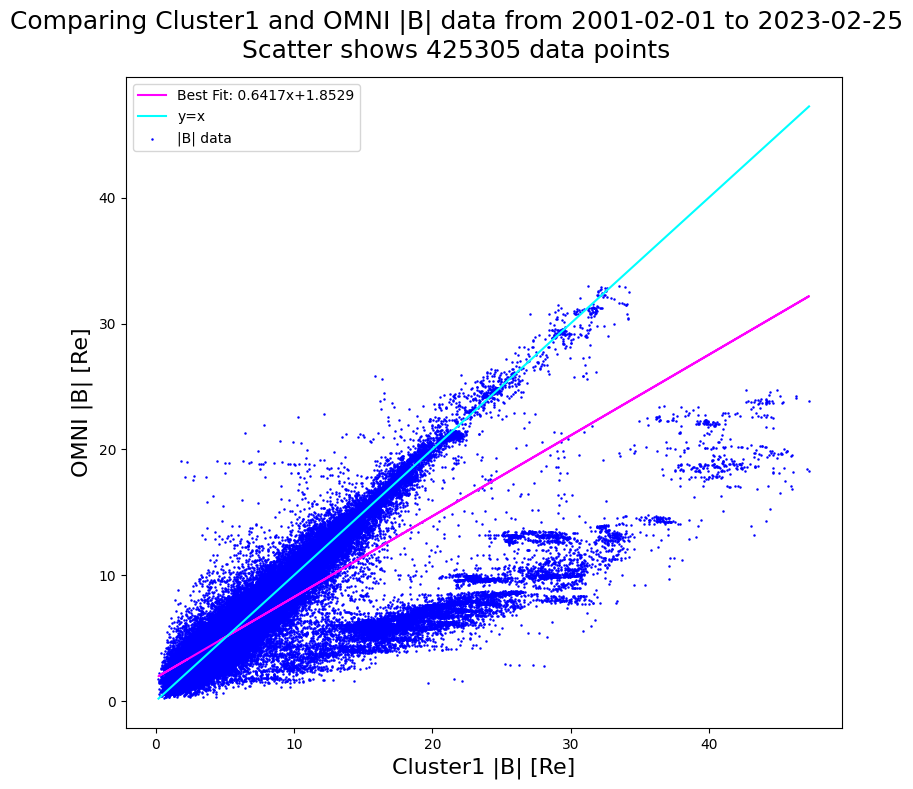

In [91]:
compare_dataframes(merged_df_sw, 'B_mag', 'Cluster1', 'OMNI', keys, display='Scatter', lines=True)

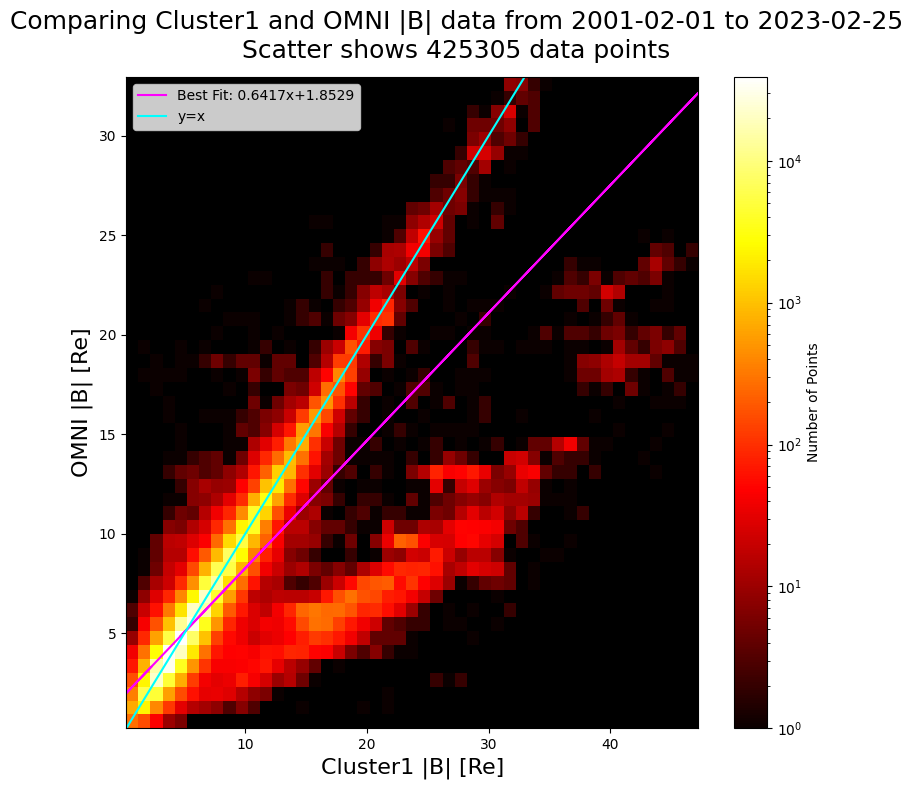

In [92]:
compare_dataframes(merged_df_sw, 'B_mag', 'Cluster1', 'OMNI', keys, display='Heat', lines=True)